# Support Vector Machines

**SVM** (Support Vector Machine) operates in a versatile way, being able to perform linear or non-linear classification, regression and novelty detection. It does not scale well with very large datasets.

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear SVM Classification

A better way to explain **SVM** is visually. In the figure below, we see in the graph on the left, attempts to separate two different classes by a line. The three attempts, although two were done correctly, got too close to the present instances.

The application of the SVM, in the graph on the right, the solid central line is called the _Decision Boundary_ of an SVM, separating the instances of the classes as much as possible at the same distance. The space between the dashed lines that separate the closest instances of each class is called _street_. And this is a **Large Margin Classification**.

It is interesting to note that, the addition of new instances _outside the streets_ does not change the _Decision Boundaries_. The only way to change the _Decision Boundary_ is through the instances called **Support Vectors**, the instances that are closest to the _Decision Boundary_ and are circled in gray in the graph.

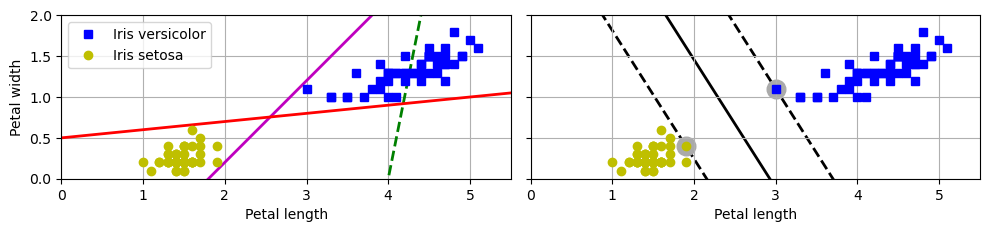

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

<div class="alert alert-block alert-danger">
<b>Attention</b>: It is necessary to pay attention to the importance of how much the scalability of the graphs can affect the analysis, as seen in the comparison below:
</div>


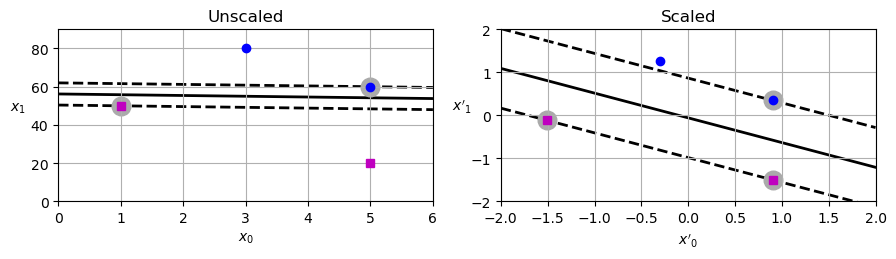

In [8]:
from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

save_fig("sensitivity_to_feature_scales_plot")
plt.show()


## Soft Margin Classification

Within the SVM, it is possible to observe two types of classification: **Hard Margin Classification** and **Soft Margin Classification**.

**Hard Margin Classification** is the one that does not allow any violation of the _Streets_, that is, any instance within this range. This ends up culminating in two problems: it only works for linearly separable classes, and it is extremely sensitive to outliers, thus having generalization problems. Below we see an example, where on the right the outlier invalidates the SVM classification, and on the right it completely alters the **Hyperplane** (or Decision Boundary):

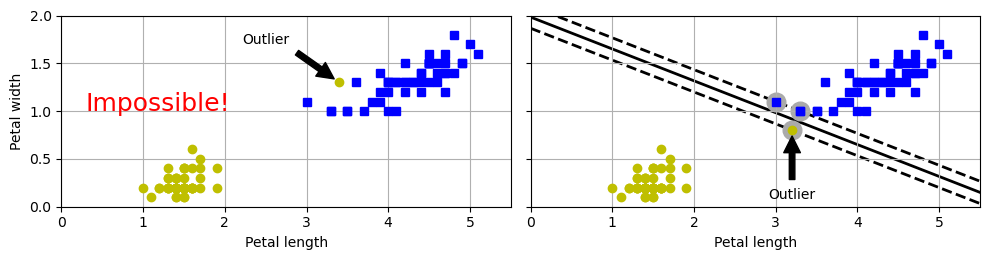

In [11]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

save_fig("sensitivity_to_outliers_plot")
plt.show()

In [13]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, dual=True, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

**Soft Margin Classification** gets around these problems by allowing values ​​in the middle of the Streets, or _Margin Violations_, and keeping the _Streets_ as wide as possible.

When applying the `SVM` class with `Scikit-Learn`, it is possible to specify the regularization hyperparameter, **C**, which in simple terms controls the **street size**:

- **C with low values** makes the streets wider, and therefore, more permissive to margin violations. In case of exaggeration, it can **cause underfitting**, and if correctly applied it can **reduce overfitting**;

- **C with high values** makes the streets thinner.

C:\Users\erhon\AppData\Local\Temp\ipykernel_6688\761820858.py:23: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
C:\Users\erhon\AppData\Local\Temp\ipykernel_6688\761820858.py:24: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()


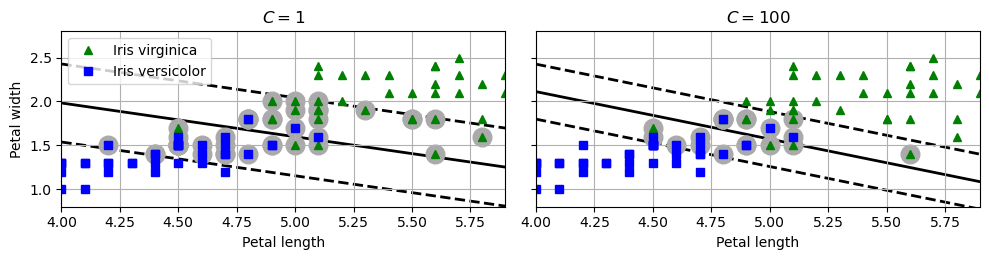

In [19]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot")
plt.show()

A brief demonstration of the predictions with the Iris virginica target:

In [ ]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

Below, the plant on the left is classified as Iris virginica and the one on the right as something different. To see the scores that the SVM used to determine this, you can use the method below, which measures the **distance between the instance and the decision boundary**:

In [ ]:
svm_clf.decision_function(X_new)

<div class="alert alert-block alert-info">
<b>Tip:</b> LinearSVC does not have the predict_proba() method. However, with the SVC class, it is possible to use both predict_proba() and predict_log_proba() by setting the probability hyperparameter to True, but this will reduce the training speed considerably.
</div>

# Nonlinear SVM Classification

In many cases, datasets do not exhibit linear behavior, requiring other approaches to try to separate the data.

One way is to add more features, so that the dataset can be treated as something linearly separable, as seen in the graph below, where the feature $x_{2} = x_{1}^{2}$ was added.

To use this on datasets, you can use a pipeline containing the `PollynomialFeatures` + `StandartScaler` + `LinearSVC` transformer.

## Polynomial Kernel

It is possible to work with polynomials in SVM, however, when using _very low degrees_ it does not fit well with complex datasets, and if using a _very high degree_ the model becomes slow and tends to _overfitting_.

**Kernel Trick** is a technique that allows you to have the same result as using a high degree polynomial without using it. It is implemented using the `SVM` class and the hyperparameter `kernel="poly"`.

[code]

On the right we see a graph of a training with a third degree polynomial, and on the right with a tenth degree.

## Similarity Features

## Gaussian RBF Kernel

## SVM Classes and Computational Complexity

# SVM Regression

**SVM Regression** operates similarly to classification. The main difference is that while _classification tries to keep instances outside the streets whenever possible_, SVM Regression aims to **have as many instances inside the streets as possible without margin violations**.

The width of the streets is controlled by the hyperparameter $\eta$. The larger this, the wider the street. **Reducing $\eta$** increases the number of _Support Vectors_, which regularizes the model, and having more instances inside the streets will not affect the predictions ($\eta$-sensitive model).

In case of non-linear problems, a _Kernelized SVM_ can be used

# Under the Hood of Linear SVM Classifiers

# The Dual Problem 

## Kernelized SVMs 